# Learning the $x$ dependency of $\mu$

## Preliminaries

In [ ]:
load("y_s_longer.RData")

%%latex

Dr. Zoh's code

In [1]:
library(brms)
library(tidyverse)

#-------------------------------------------------------------------------------
#--- Useful functions
#-- find the root
#-------------------------------------------------------------------------------
GamF <- function(gam, p0) {
    (2 * pnorm(-abs(gam)) * exp(.5 * gam^2) - p0)^2
}

# optimize(GamF,interval = c(-30,30), p0=1 - 0.05)
GamBnd <- function(p0) {
    Re1 <- optimize(GamF, interval = c(-30, 30), p0 = 1 - p0)
    Re2 <- optimize(GamF, interval = c(-30, 30), p0 = p0)

    c(-abs(Re1$minimum), abs(Re2$minimum), Re1$objective, Re2$objective)
}
GamBnd <- Vectorize(GamBnd, "p0")

#-------------------------------------------------------------------------------
#--- Function
#-------------------------------------------------------------------------------
#--- Stan function (case 2)
tau0 <- .1


Bd <- GamBnd(tau0)[1:2]
# GAL2 <- custom_family(
#  "GAL2", dpars = c("mu", "sigma","ligam", "tau","gamL","gamU"), links=c("identity","log","identity","identity", rep("identity",2)),
#  lb=c(NA,0, -1.087,0,NA,NA), ub=c(NA,NA, 1.087,1,NA,NA), type="real") #, vars = "vint1[n]"
# GAL2 <- custom_family(
#   "GAL2", dpars = c("mu", "sigma","ligam"), links= c("identity","log","identity"),
#   lb=c(NA,0, -1.087), ub=c(NA,NA, 1.087), type="real", vars = c("tau","gamL","gamU")) #, vars = "vint1[n]"
GAL2 <- custom_family(
    "GAL2",
    dpars = c("mu", "sigma", "ligam", "tau"), links = c("identity", "log", "identity", "identity"),
    lb = c(NA, 0, -1.086, 0), ub = c(NA, NA, 1.086, 1), type = "real"
) # , vars = c("tau")) #, vars = "vint1[n]"

GAL2 <- custom_family(
    "GAL2",
    dpars = c("mu", "sigma", "ligam", "tau"), links = c("identity", "log", "logit", "identity"),
    lb = c(NA, 0, -15, 0), ub = c(NA, NA, 15, 1), type = "real", vars = c("gamL", "gamU")
) # , vars = c("tau")) #, vars = "vint1[n]"

GAL2 <- custom_family(
    "GAL2",
    dpars = c("mu", "sigma", "ligam", "tau", "gamL", "gamU"), links = c("identity", "log", "identity", "identity", rep("identity", 2)),
    lb = c(NA, 0, -15, 0, NA, NA), ub = c(NA, NA, 15, 1, NA, NA), type = "real"
) # , vars = "vint1[n]"

GAL2 <- custom_family(
    "GAL2",
    dpars = c("mu", "sigma", "ligam", "tau"), links = c("identity", "log", "identity", "identity"),
    lb = c(NA, 0, Bd[1] * .99, 0), ub = c(NA, NA, Bd[2] * .99, 1), type = "real"
) # , vars = "vint1[n]"


stan_funs2 <- "
    /*
    A = -est*p_neg + .5*pow(gam, 2)*pow(p_neg/p_pos, 2) + log(Phi_approx(a2-a3)) + log1m_exp(fabs(log(Phi_approx(a2-a3)) - log(Phi_approx(a2))));
  gam = (gamU - gamL) * ligam + gamL;
  real gam = (gamU - gamL) * ligam + gamL;
  real GAL2_lpdf(real y, real mu, real sigma, real ligam, real tau, real gamL, real gamU){
  real GAL2_rng(real mu, real sigma, real ligam, real tau, real gamL, real gamU){
   */
     /* helper function for asym_laplace_lpdf
  * Args:
    *   y: the response value
  *   tau: quantile parameter in (0, 1)
  */
    real rho_quantile(real y, real tau) {
      if (y < 0) {
        return y * (tau - 1);
      } else {
        return y * tau;
      }
    }
  /* asymmetric laplace log-PDF for a single response
  * Args:
    *   y: the response value
  *   mu: location parameter
  *   sigma: positive scale parameter
  *   tau: quantile parameter in (0, 1)
  * Returns:
    *   a scalar to be added to the log posterior
  */
    real asym_laplace_lpdf(real y, real mu, real sigma, real tau) {
      return log(tau * (1 - tau)) -
        log(sigma) -
        rho_quantile((y - mu) / sigma, tau);
    }
  /* asymmetric laplace log-CDF for a single quantile
  * Args:
    *   y: a quantile
  *   mu: location parameter
  *   sigma: positive scale parameter
  *   tau: quantile parameter in (0, 1)
  * Returns:
    *   a scalar to be added to the log posterior
  */
    real asym_laplace_lcdf(real y, real mu, real sigma, real tau) {
      if (y < mu) {
        return log(tau) + (1 - tau) * (y - mu) / sigma;
      } else {
        return log1m((1 - tau) * exp(-tau * (y - mu) / sigma));
      }
    }
  /* asymmetric laplace log-CCDF for a single quantile
  * Args:
    *   y: a quantile
  *   mu: location parameter
  *   sigma: positive scale parameter
  *   tau: quantile parameter in (0, 1)
  * Returns:
    *   a scalar to be added to the log posterior
  */
    real asym_laplace_lccdf(real y, real mu, real sigma, real tau) {
      if (y < mu) {
        return log1m(tau * exp((1 - tau) * (y - mu) / sigma));
      } else {
        return log1m(tau) - tau * (y - mu) / sigma;
      }
    }

   real GAL2_lpdf(real y, real mu, real sigma, real ligam, real tau){

   real p_pos;
   real p_neg;
   real a3;
   real a2;
   real p;
   real est;
   real A;
   real B;
   real Res = 0;
   real gam = ligam;
    p = (gam < 0) + (tau - (gam < 0))/(2*Phi(-fabs(gam))*exp(.5*pow(gam, 2)));
    p_pos = p -  (gam > 0);
    p_neg = p -  (gam < 0);
    est = (y - mu) / sigma;

    if(fabs(gam) > 0){
    a3 = p_pos * (est / fabs(gam));
    a2 = fabs(gam) * (p_neg / p_pos);


    if(est/gam > 0){
      A =  0.5*pow(gam, 2)*pow(p_neg/p_pos, 2) - est*p_neg + log_diff_exp(log(Phi_approx(a2-a3)), log(Phi_approx(a2)) );
      B =  0.5*pow(gam, 2) - p_pos*est + log(Phi_approx(-fabs(gam) + a3));
      Res = log(2*p*(1-p)) - log(sigma) +  log_sum_exp(A, B);
    }else{
      Res =  log(2*p*(1-p)) - log(sigma) - p_pos * est + 0.5 * pow(gam, 2) + log(Phi_approx(-fabs(gam) ));
    }
    }else{
    Res = asym_laplace_lpdf( y | mu, sigma, tau);
    }

    return Res;
   }

  real GAL2_rng(real mu, real sigma, real ligam, real tau){

     real A;
     real B;
     real C;
     real p;
     real hi;
     real nui;
     real mui=0;
     real Up = uniform_rng(.5, 1.0);

     real gam = ligam;
     p = (gam < 0) + (tau - (gam < 0))/(2*Phi_approx(-fabs(gam))*exp(.5*pow(gam, 2)));
     A = (1 - 2*p)/(p - pow(p,2));
     B = 2/(p - pow(p,2));
     C = 1/((gam > 0) - p);

      hi = sigma * inv_Phi(Up);
     nui = sigma * exponential_rng(1);
     mui += mu + A * nui + C * fabs(gam) * hi;

     return normal_rng(mui, sqrt(sigma*B*nui));
  }
  "


#--- Now define all of these here
# stanvars <- stanvar(scode = stan_funs, block = "functions")
stanvars2 <- stanvar(scode = stan_funs2, block = "functions")

# priorval = c(prior(normal(0, 15), class = "Intercept"),
#           # Prior guess of 80% of the terms are non-zero
#           prior(horseshoe(par_ratio =0.8), class = "b"))

#--- Fit the quantile regression
#-- quantile

# fit_fakeq.5 <- brms::brm(bf(as.formula(form), quantile = .5), data = df_sampleWt, family = asym_laplace(), prior = set_prior(horseshoe(df=1,par_ratio = 0.1), class="b"))
# fit_fakeq.5 <- brms::brm(bf(as.formula(form), quantile = .5), data = df_sampleWt, family = asym_laplace())

# fit_fakeqGal.5 <- brms::brm(bf(as.formula(form), tau = .5, gamL = Bd[1], gamU = Bd[2]), data = df_sampleWt, family = GAL,
#                             stanvars = stanvars,chains = 3,iter = 10000, control = list(adapt_delta = 0.97, max_treedepth = 10))


# fit_fakeqGal2.5 <- brms::brm(bf(as.formula(form), tau = .5, gamL = Bd[1], gamU = Bd[2]), data = df_sampleWt, family = GAL2, stanvars = stanvars2,chains = 3,iter = 1000)
# fit_fakeqGal2.5 <- brms::brm(bf(as.formula(form), tau = .5,gamL = Bd[1], gamU = Bd[2]), data = df_sampleWt, family = GAL2, stanvars = stanvars2,chains = 2,iter = 2000, init = 0.1, control = list(adapt_delta = 0.97))

# fit_fakeqGal2.5 <- brms::brm(bf(as.formula(form), tau = tau0), data = df_sampleWt, family = GAL2, stanvars = stanvars2,chains = 2,iter = 5000, control = list(adapt_delta = 0.97)) # init = 0.1,
# fit_fakeqGal2.9 <- brms::brm(bf(as.formula(form), tau = tau0), data = df_sampleWt, family = GAL2, stanvars = stanvars2,chains = 2,iter = 5000, control = list(adapt_delta = 0.97)) # init = 0.1,
# fit_fakeqGal2.1 <- brms::brm(bf(as.formula(form), tau = tau0), data = df_sampleWt, family = GAL2, stanvars = stanvars2,chains = 2,iter = 5000, control = list(adapt_delta = 0.97)) # init = 0.1,


Loading required package: Rcpp

Loading 'brms' package (version 2.18.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: ‘brms’


The following object is masked from ‘package:stats’:

    ar


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.1 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Data with exponentially increasing heteroskedasticity

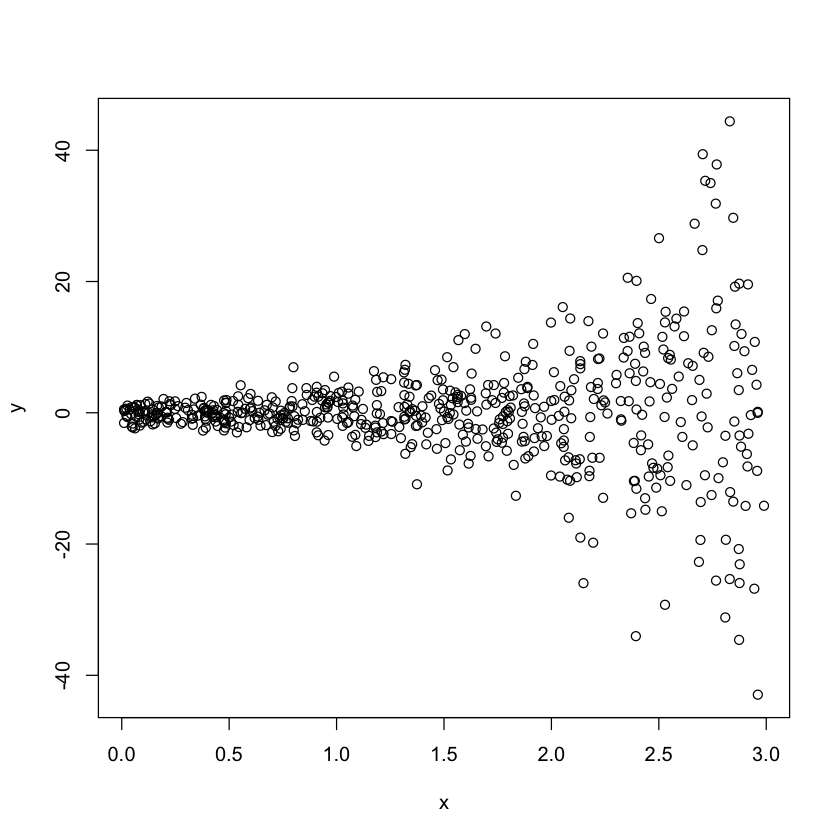

In [5]:
N <- 600
x <- runif(N, 0, 3)
y <- rnorm(N, mean = 0, sd = exp(x))

synthetic <- data.frame(x = x, y = y)
plot(x, y)

## Models

### .25 quantile

Fitting $\sigma$

In [6]:
Bd <- GamBnd(.25)[1:2]
GAL2 <- custom_family(
    "GAL2",
    dpars = c("mu", "sigma", "ligam", "tau"), links = c("identity", "log", "identity", "identity"),
    lb = c(NA, 0, Bd[1] * .9, 0), ub = c(NA, NA, Bd[2] * .9, 1), type = "real"
)
q25 <- brm(bf(y ~ s(x), sigma ~ x, tau = .25), data = synthetic, family = GAL2, stanvars = stanvars2, chains = 2, iter = 2000, control = list(adapt_delta = 0.99), cores = 4, seed = 123)
summary(q25)

Compiling Stan program...

Start sampling



 Family: GAL2 
  Links: mu = identity; sigma = log; ligam = identity; tau = identity 
Formula: y ~ s(x) 
         sigma ~ x
         tau = 0.25
   Data: synthetic (Number of observations: 600) 
  Draws: 2 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 2000

Smooth Terms: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sds(sx_1)     3.40      1.69     0.99     7.72 1.00     1010     1063

Population-Level Effects: 
                Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept          -3.27      0.37    -3.99    -2.58 1.00     1381     1436
sigma_Intercept    -1.25      0.10    -1.45    -1.06 1.00     1349     1398
sigma_x             1.04      0.04     0.96     1.11 1.00     2109     1654
sx_1              -17.28      7.98   -35.16    -3.41 1.00      944     1079

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
ligam     1.33      0.13     1.06     1

Warning message:
“The following parameters were dropped because they are constant: tau”


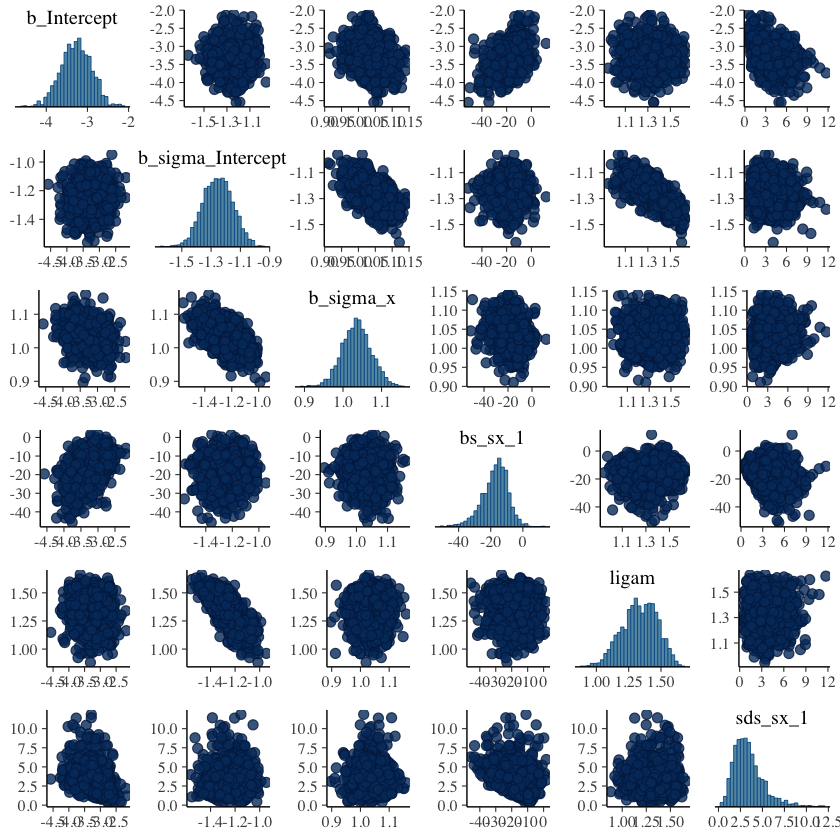

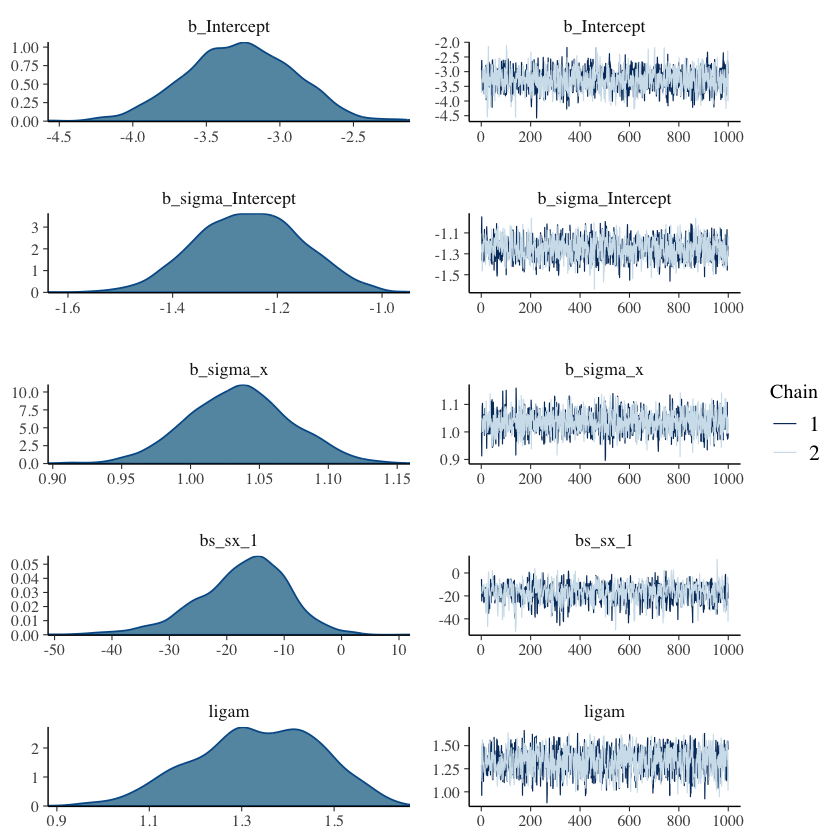

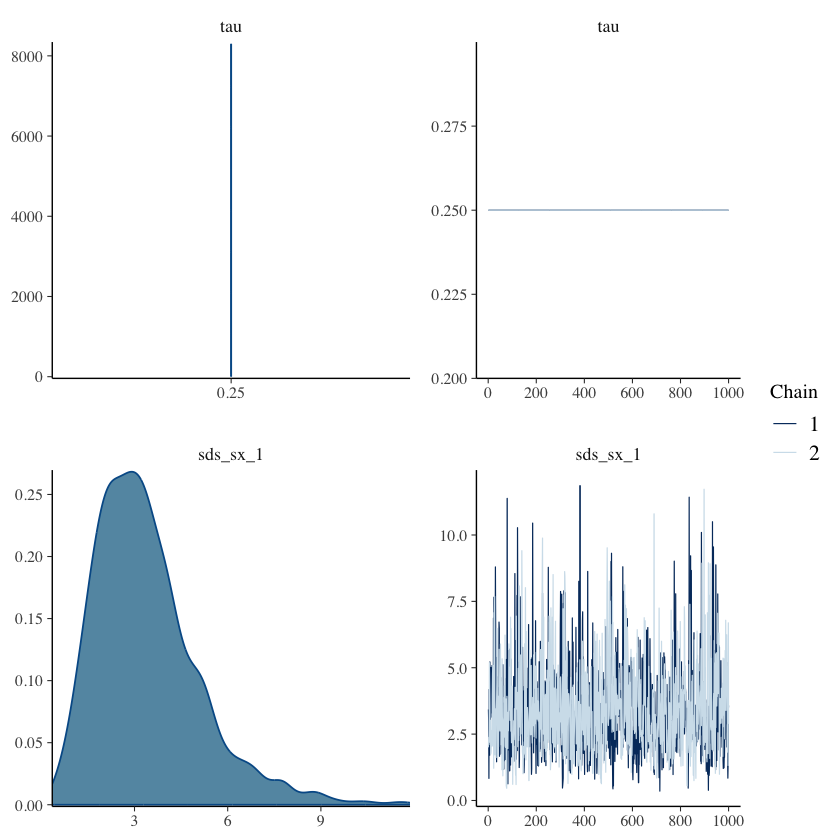

In [7]:
pairs(q25)
plot(q25)

Not fitting $\sigma$

In [8]:
q25n <- brm(bf(y ~ s(x), tau = .25), data = synthetic, family = GAL2, stanvars = stanvars2, chains = 2, iter = 2000, control = list(adapt_delta = 0.99), cores = 4, seed = 123)
summary(q25n)

Compiling Stan program...

Start sampling

Warning message:
“There were 1267 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 632 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
https://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess”
Warning messag

 Family: GAL2 
  Links: mu = identity; sigma = identity; ligam = identity; tau = identity 
Formula: y ~ s(x) 
         tau = 0.25
   Data: synthetic (Number of observations: 600) 
  Draws: 2 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 2000

Smooth Terms: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sds(sx_1)     2.19      2.01     0.08     7.41 1.01      143      223

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept    -3.31      0.28    -3.88    -2.80 1.01      232      196
sx_1         -7.65      6.89   -24.44     2.50 1.02      130      142

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     2.30      0.09     2.13     2.49 1.00      266      486
ligam     0.69      0.05     0.61     0.81 1.01      118      114
tau       0.25      0.00     0.25     0.25   NA       NA       NA

Draws were sampled using

Warning message:
“The following parameters were dropped because they are constant: tau”


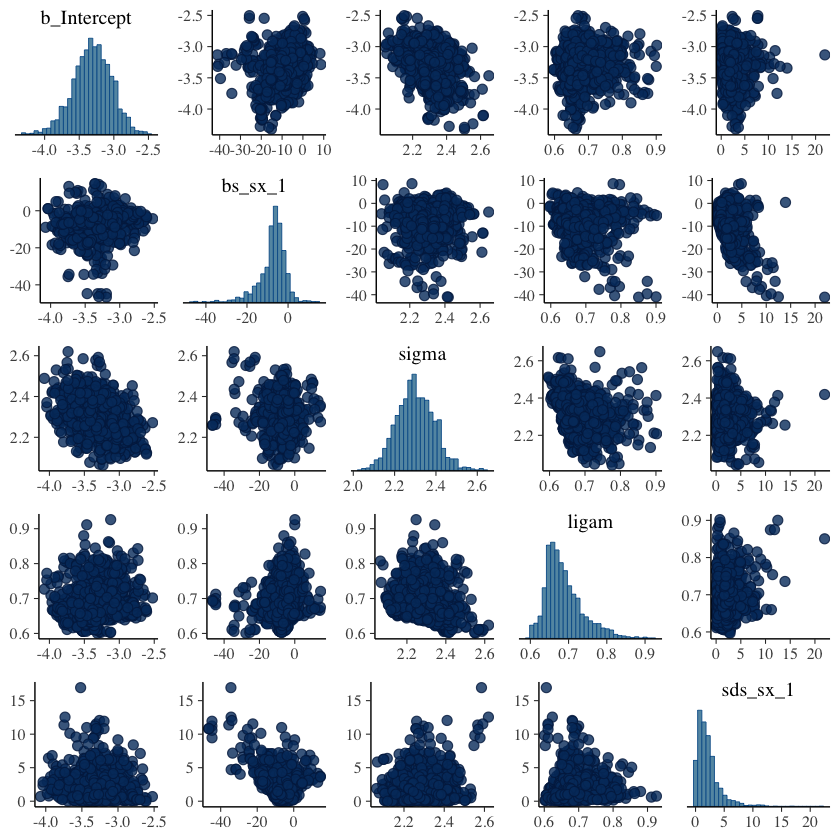

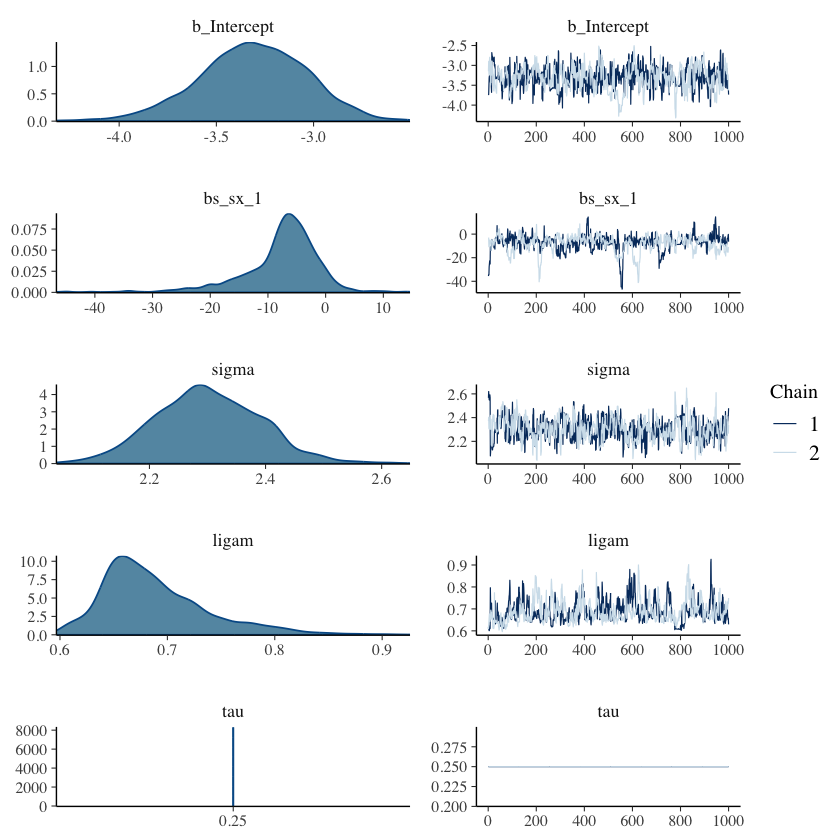

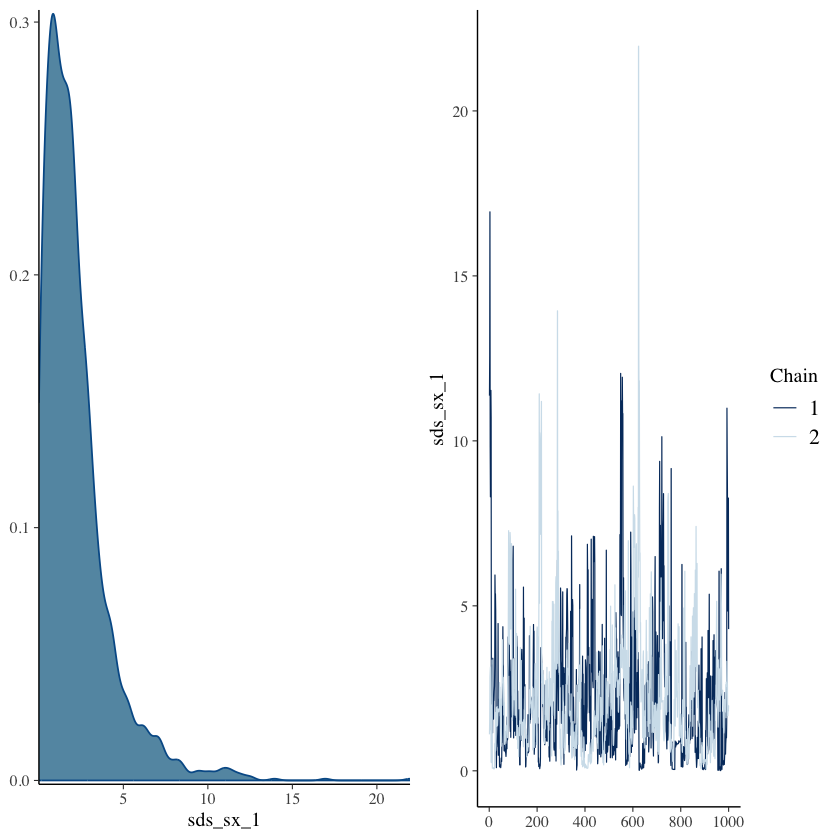

In [9]:
pairs(q25n)
plot(q25n)

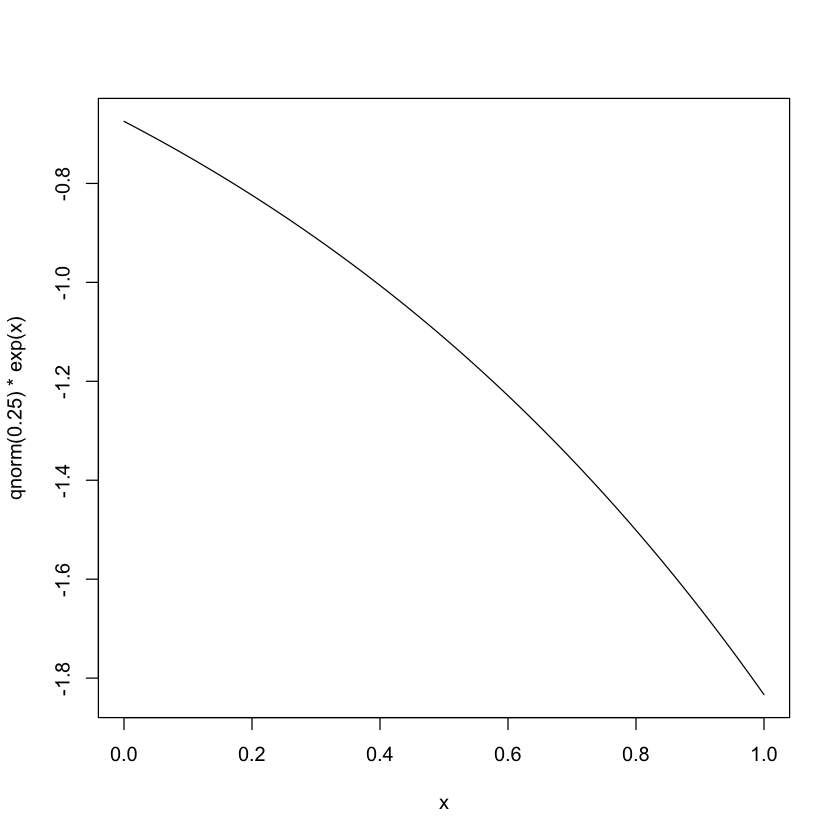

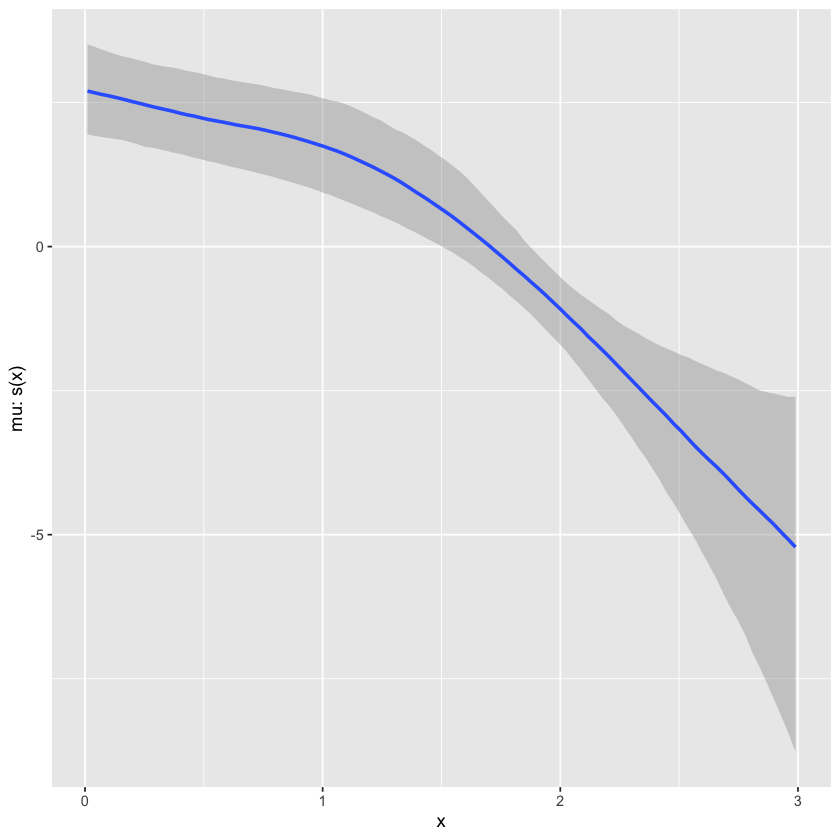

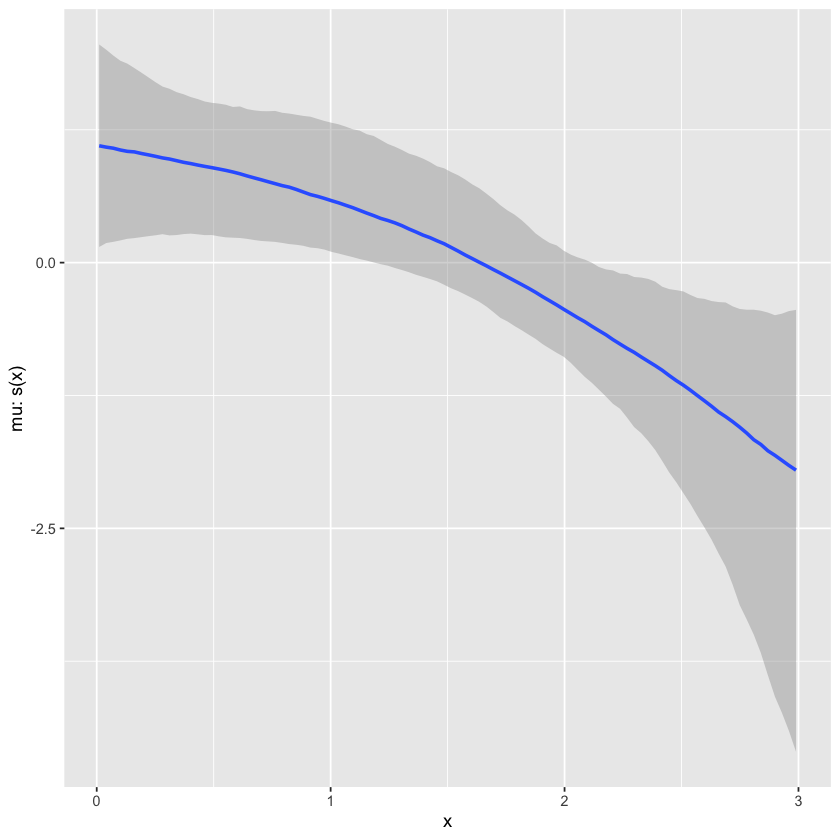

In [10]:
csq25 <- conditional_smooths(q25)
csq25n <- conditional_smooths(q25n)
curve(qnorm(.25)*exp(x), from = 0, to = 1)
plot(csq25)
plot(csq25n)

Comparing the two models

In [11]:
# Exposing the functions from stan to r
posterior_predict_GAL2 <- function(i, prep, ...){
  mu <- brms::get_dpar(prep, 'mu', i = i)
  sigma <- brms::get_dpar(prep, 'sigma', i = i)
  ligam <- brms::get_dpar(prep, 'ligam', i = i)
  tau <- brms::get_dpar(prep, 'tau', i = i)
  GAL2_rng(mu, sigma, ligam, tau)
}
expose_functions(q25, vectorize = TRUE)

log_lik_GAL2 <- function(i, prep) {
    mu <- brms::get_dpar(prep, "mu", i = i)
    sigma <- brms::get_dpar(prep, "sigma", i = i)
    ligam <- brms::get_dpar(prep, "ligam", i = i)
    tau <- brms::get_dpar(prep, "tau", i = i)
    y <- prep$data$Y[i]
    GAL2_lpdf(y, mu, sigma, ligam, tau)
}

# Compare the two models using loo
q25 <- add_criterion(q25, "waic")
q25n <- add_criterion(q25n, "waic")

loo_compare(q25, q25n, criterion = "waic")


,elpd_diff,se_diff,elpd_waic,se_elpd_waic,p_waic,se_p_waic,waic,se_waic
q25,0.0000,0.00000,-1725.142,28.45929,6.701755,0.2813206,3450.284,56.91858
q25n,-274.0631,19.64011,-1999.205,33.94548,7.289573,0.5697964,3998.410,67.89095


### .5 quantile

In [12]:
Bd <- GamBnd(.5)[1:2]
GAL2 <- custom_family(
    "GAL2",
    dpars = c("mu", "sigma", "ligam", "tau"), links = c("identity", "log", "identity", "identity"),
    lb = c(NA, 0, Bd[1] * .9, 0), ub = c(NA, NA, Bd[2] * .9, 1), type = "real"
)
q50 <- brm(bf(y ~ s(x), sigma ~ x, tau = .5), data = synthetic, family = GAL2, stanvars = stanvars2, chains = 2, iter = 2000, control = list(adapt_delta = 0.99), cores = 4, seed = 123)
summary(q50)

Compiling Stan program...

Start sampling

Warning message:
“There were 1587 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is NA, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess”
Warning message:
“Parts of the model 

 Family: GAL2 
  Links: mu = identity; sigma = log; ligam = identity; tau = identity 
Formula: y ~ s(x) 
         sigma ~ x
         tau = 0.5
   Data: synthetic (Number of observations: 600) 
  Draws: 2 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 2000

Smooth Terms: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sds(sx_1)     1.77      1.67     0.08     6.34 1.04      115      263

Population-Level Effects: 
                Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept           0.18      0.45    -0.62     1.03 1.67        3       97
sigma_Intercept    -1.05      0.08    -1.21    -0.89 1.03      100      367
sigma_x             1.05      0.05     0.96     1.14 1.01      264      582
sx_1                0.89      5.16   -10.57    13.18 1.03      262      255

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
ligam    -0.02      0.25    -0.40     0.

In [13]:
q50n <- brm(bf(y ~ s(x), tau = .50), data = synthetic, family = GAL2, stanvars = stanvars2, chains = 2, iter = 2000, control = list(adapt_delta = 0.99), cores = 4, seed = 123)
summary(q50n)

Compiling Stan program...

Start sampling

Warning message:
“There were 1993 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is NA, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess”
Warning message:
“Parts of the model 

 Family: GAL2 
  Links: mu = identity; sigma = identity; ligam = identity; tau = identity 
Formula: y ~ s(x) 
         tau = 0.5
   Data: synthetic (Number of observations: 600) 
  Draws: 2 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 2000

Smooth Terms: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sds(sx_1)     3.15      1.55     1.04     7.58 1.04       49       74

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept    -0.40      0.30    -1.08     0.12 1.15       12       38
sx_1        -10.91      5.82   -20.09    -1.55 1.32        5       15

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     2.38      0.12     2.18     2.69 1.05       36       44
ligam    -0.30      0.02    -0.33    -0.27 1.05       32       42
tau       0.50      0.00     0.50     0.50   NA       NA       NA

Draws were sampled using 

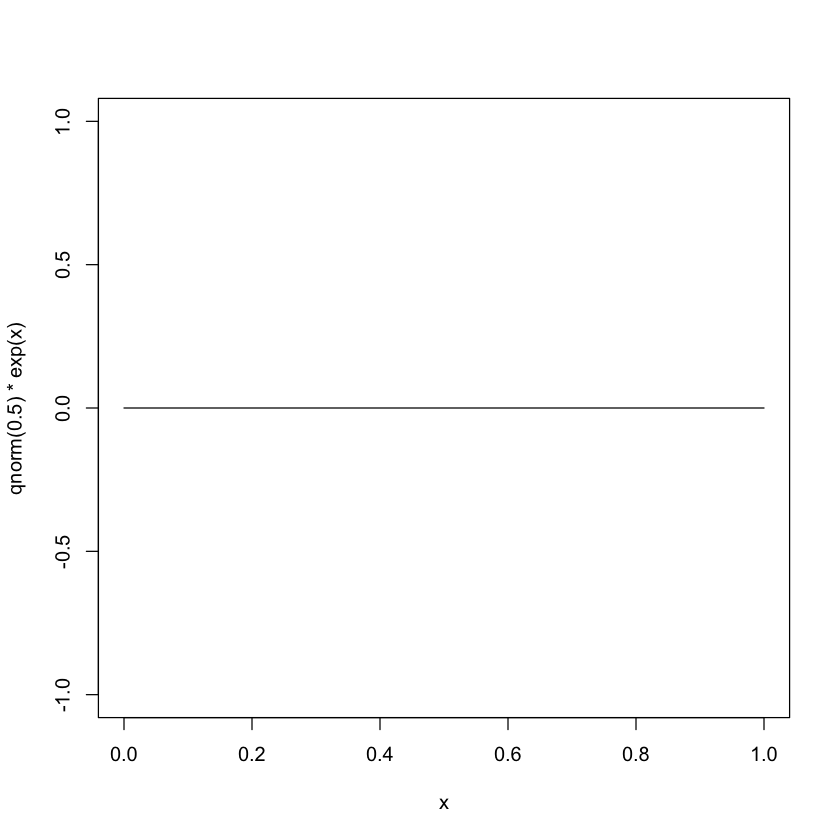

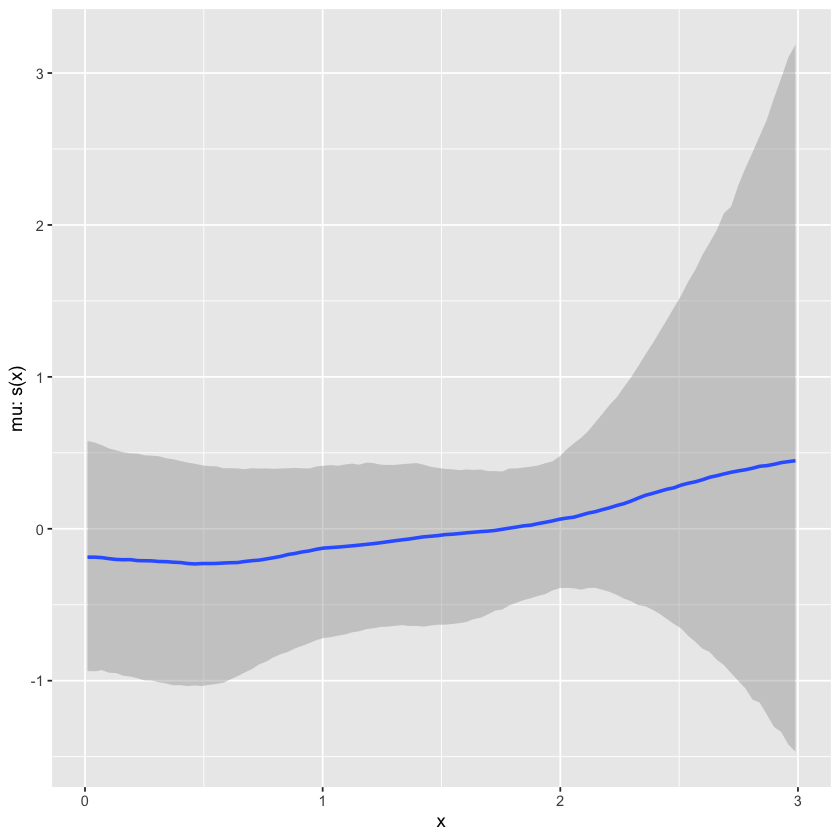

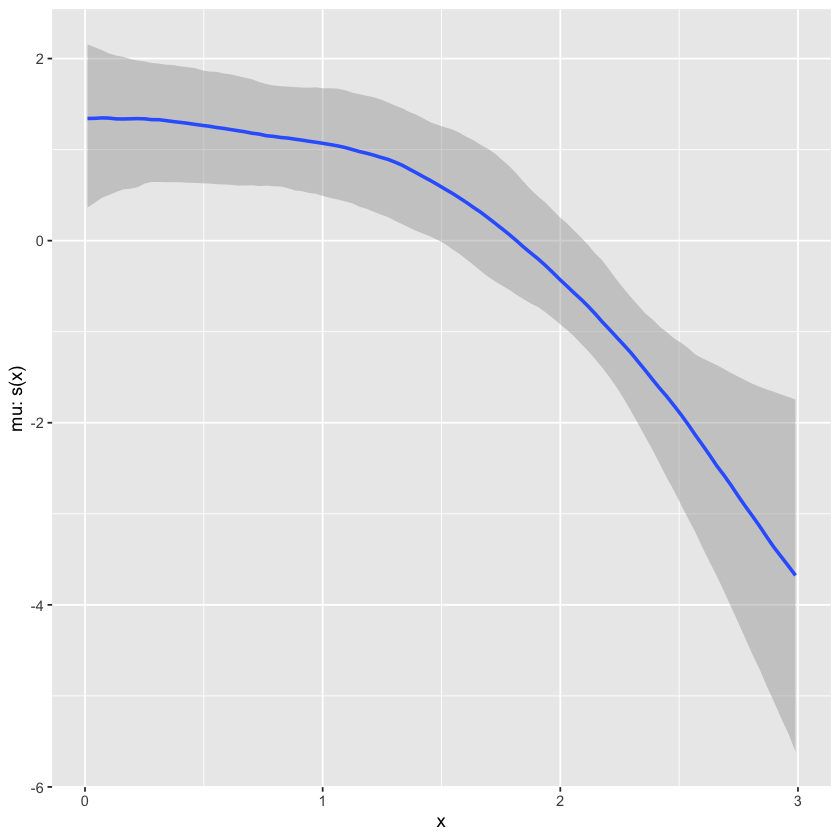

In [14]:
csq50 <- conditional_smooths(q50)
csq50n <- conditional_smooths(q50n)
curve(qnorm(.5)*exp(x), from = 0, to = 1)
plot(csq50)
plot(csq50n)

### .75 quantile

In [15]:
Bd <- GamBnd(.75)[1:2]
GAL2 <- custom_family(
    "GAL2",
    dpars = c("mu", "sigma", "ligam", "tau"), links = c("identity", "log", "identity", "identity"),
    lb = c(NA, 0, Bd[1] * .9, 0), ub = c(NA, NA, Bd[2] * .9, 1), type = "real"
)
q75 <- brm(bf(y ~ s(x), sigma ~ x, tau = .75), data = synthetic, family = GAL2, stanvars = stanvars2, chains = 2, iter = 2000, control = list(adapt_delta = 0.99), cores = 4, seed = 123)
summary(q75)

Compiling Stan program...

Start sampling



 Family: GAL2 
  Links: mu = identity; sigma = log; ligam = identity; tau = identity 
Formula: y ~ s(x) 
         sigma ~ x
         tau = 0.75
   Data: synthetic (Number of observations: 600) 
  Draws: 2 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 2000

Smooth Terms: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sds(sx_1)     4.00      2.02     1.38     9.00 1.00      764     1246

Population-Level Effects: 
                Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept           3.63      0.36     2.96     4.33 1.00     1488     1591
sigma_Intercept    -1.26      0.10    -1.45    -1.07 1.00     1207     1455
sigma_x             1.03      0.04     0.95     1.11 1.00     1758     1389
sx_1               19.65      9.15     3.68    39.45 1.00      959     1114

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
ligam    -1.35      0.13    -1.58    -1

In [16]:
q75n <- brm(bf(y ~ s(x), tau = .75), data = synthetic, family = GAL2, stanvars = stanvars2, chains = 2, iter = 2000, control = list(adapt_delta = 0.99), cores = 4, seed = 123)
summary(q75n)

Compiling Stan program...

Start sampling

Warning message:
“There were 1084 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 845 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
https://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is NA, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicatin

 Family: GAL2 
  Links: mu = identity; sigma = identity; ligam = identity; tau = identity 
Formula: y ~ s(x) 
         tau = 0.75
   Data: synthetic (Number of observations: 600) 
  Draws: 2 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 2000

Smooth Terms: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sds(sx_1)     2.62      2.00     0.13     8.21 1.02       62       45

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     3.70      0.25     3.26     4.21 1.02       97      308
sx_1          9.83      7.58    -4.63    22.81 1.08       24       44

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     2.28      0.08     2.12     2.45 1.05       56      208
ligam    -0.69      0.04    -0.78    -0.62 1.02       99      164
tau       0.75      0.00     0.75     0.75   NA       NA       NA

Draws were sampled using

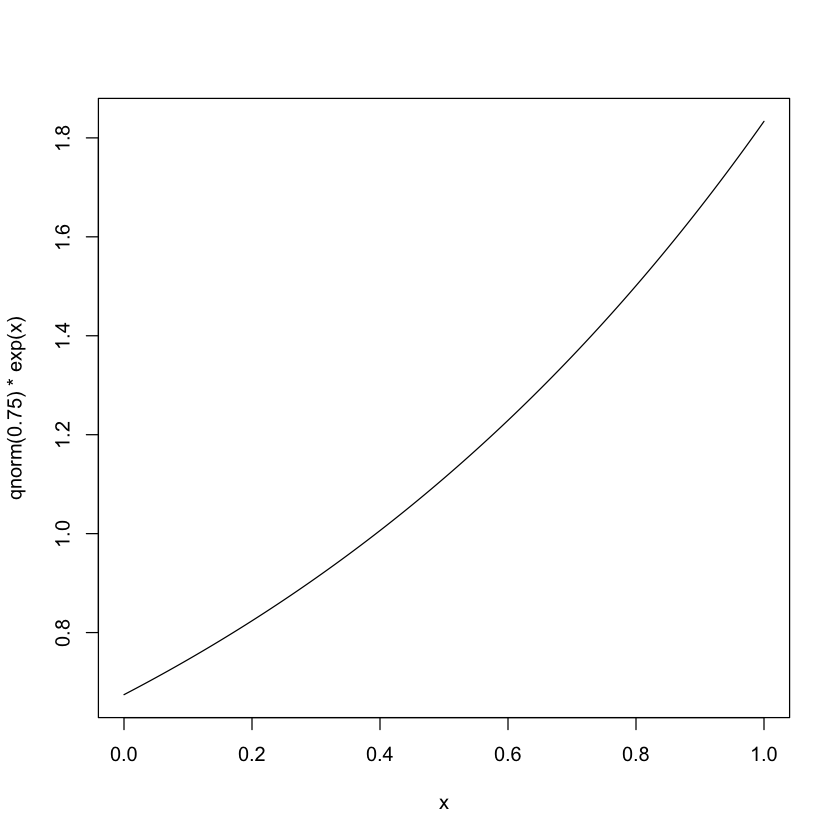

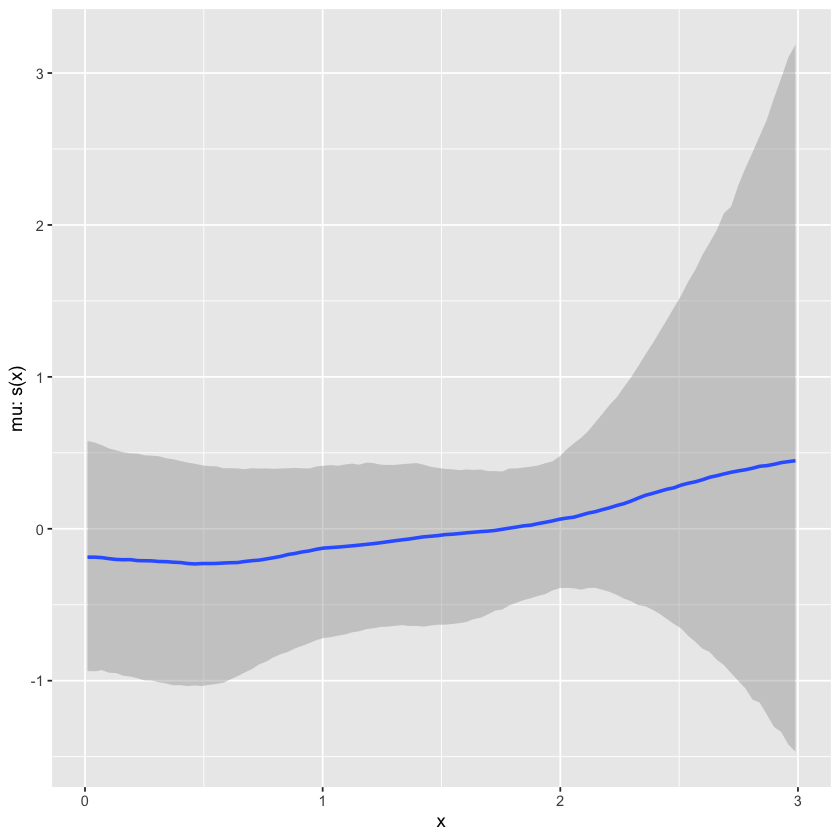

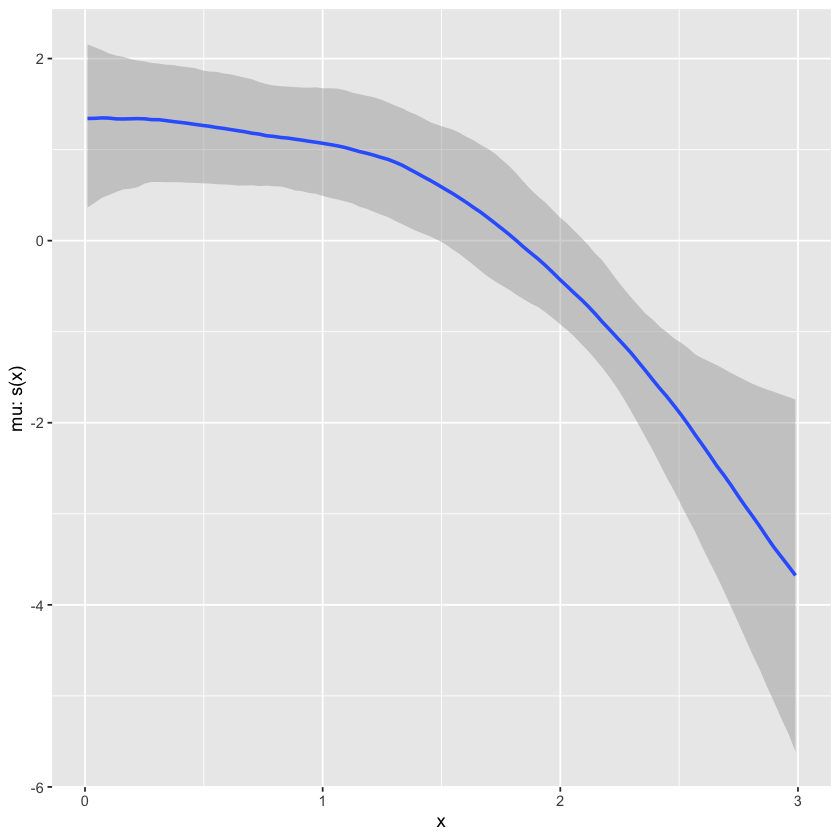

In [17]:
csq75 <- conditional_smooths(q50)
csq75n <- conditional_smooths(q50n)
curve(qnorm(.75)*exp(x), from = 0, to = 1)
plot(csq75)
plot(csq75n)

## Saving and loading

In [18]:
save(file = "y_s_longer.RData", list = ls())